#  This script is written for preprocessing EEG, EMG for RJ-iVC paradigm iVC: isokinetic/isovelocity contraction. This scripts is organized as follows: iVC prep fcs then the synthesized function. 

## Specification of customization (things have to be changed):
- contraction_type can be either 'iMC' or 'iVC'
- session_idx for iMC is 's01' (pre-TMS) and 's02' (after-TMS), for iVC can be 's01' to 's06' with 's01'-'s03' prior to TMS
- After 15 days' therapy, session_idx for iMC is 's03' (pre-TMS) and 's04' (after-TMS), for iVC can be 's07' to 's012' with 's07'-'s09' prior to TMS
- please note that in official data processing, each subject can have only iMC or iVC data

## naming for preped files:
- for each session, the pushing epochs and pulling epochs are saved separately

## Some notes for implementation:


# Step 0: Global definition
The dict and relating script should be update/rerun every time the user spot a bad channel

In [98]:
bad_eeg_chs = {'2':
               {'iMC':{'s01':['T8','C3','CP6'],'s02':[]},
                'iVC':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]}
               },
               '3':
               {'iMC':{'s01':[],'s02':[]},
                'iVC':{'s01':['T8','T7'],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]}
               },
                '4':
               {'iMC':{'s01':['Pz','T8'],'s02':['T8']},
                'iVC':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]}
               },
               '6':
               {'iMC':{'s01':[],'s02':[]},
                'iVC':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]}
               }
              }
ICs2remove = {'2':
               {'iMC':{'s01':[9,10],'s02':[]},
                'iVC_push':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'iVC_pull':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
               },
              '3':
               {'iMC':{'s01':[],'s02':[]},
                'iVC_push':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'iVC_pull':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
               },
                '4':
               {'iMC':{'s01':[0,3],'s02':[0]},
                'iVC_push':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'iVC_pull':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
               },
               '6':
               {'iMC':{'s01':[],'s02':[]},
                'iVC_push':{'s01':[0,5],'s02':[0,1,5],'s03':[0,3,12],'s04':[0,1,7],'s05':[0,1],'s06':[0,5]},
                'iVC_pull':{'s01':[0],'s02':[0,1],'s03':[0],'s04':[0,1],'s05':[0],'s06':[0]},
               }
              }

# Step 1 : Visualization of EEG to spot bad channels
note that once the bad channels have been identified, you have to run this script twice to mark the bad channels

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 sec)



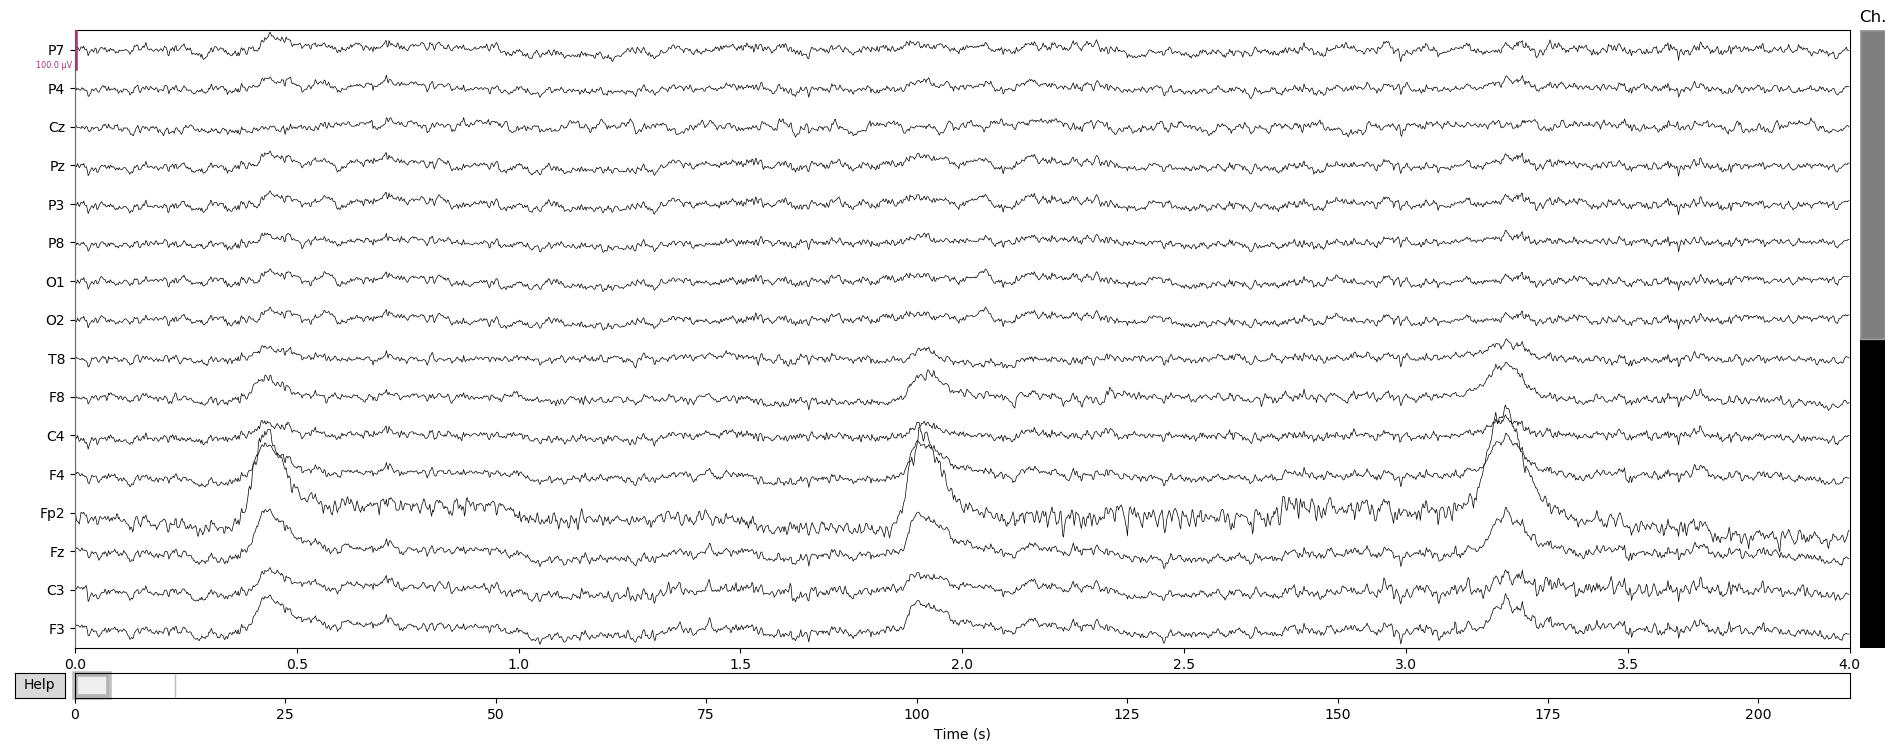

In [89]:
################## Import #####################
import os,mne,numpy as np, pandas as pd
from mne.preprocessing import ICA
%matplotlib qt
#############################################

################## Customization ##################
data_dir = 'D:/Data/MultiEEGEMG_stroke/'
subj_idx = '6'
contraction_type = 'iVC'
session_idx = 's06'
sfreq_emg=1000
sfreq_eeg=500
reject_criteria_eeg = dict(eeg=6e-4)       # 300 μV, do not exclude epochs containing ocular artifact
flat_criteria_eeg = dict(eeg=1e-6)           # 1 μV


################ fName
emg_fName = os.path.join(data_dir,'subj'+subj_idx,'EMG','subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'.txt')
eeg_fName = os.path.join(data_dir,'subj'+subj_idx,'EEG','subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'.set')
ica_dir = os.path.join(data_dir,'subj'+subj_idx,'ica')
epochs_beforeICA_dir = os.path.join(data_dir,'subj'+subj_idx,'epochs_beforeICA')
epochs_preped_dir = os.path.join(data_dir,'subj'+subj_idx,'epochs_preped')
epochs_hybrid_dir = os.path.join(data_dir,'subj'+subj_idx,'epochs_hybrid')
if not os.path.exists(ica_dir):
    os.makedirs(ica_dir)
if not os.path.exists(epochs_beforeICA_dir):
    os.makedirs(epochs_beforeICA_dir)
if not os.path.exists(epochs_preped_dir):
    os.makedirs(epochs_preped_dir)
if not os.path.exists(epochs_hybrid_dir):
    os.makedirs(epochs_hybrid_dir)
    
ica_push_fName = os.path.join(data_dir,
                              'subj'+subj_idx,'ica','subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_push_ica.fif')
ica_pull_fName = os.path.join(data_dir,
                              'subj'+subj_idx,'ica','subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_pull_ica.fif')

epochs_beforeICA_push_fName = os.path.join(data_dir,'subj'+subj_idx,'epochs_beforeICA',
                                      'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_beforeICA_push_epo.fif')
epochs_beforeICA_pull_fName = os.path.join(data_dir,'subj'+subj_idx,'epochs_beforeICA',
                                      'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_beforeICA_pull_epo.fif')

epochs_preped_push_fName = os.path.join(data_dir,'subj'+subj_idx,'epochs_preped',
                                      'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_preped_push_epo.fif')
epochs_preped_pull_fName = os.path.join(data_dir,'subj'+subj_idx,'epochs_preped',
                                      'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_preped_pull_epo.fif')

epochs_hybrid_push_fName = os.path.join(data_dir,'subj'+subj_idx,'epochs_hybrid',
                                      'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_hybrid_push_epo.fif')
epochs_hybrid_pull_fName = os.path.join(data_dir,'subj'+subj_idx,'epochs_hybrid',
                                      'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_hybrid_pull_epo.fif')

alignmentInfo_fName = os.path.join(data_dir,'subj'+subj_idx,'subj'+subj_idx+'_alignmentInfo.txt')
alignmentInfo = pd.read_csv(alignmentInfo_fName, skiprows=0,
                       sep = ',',engine = 'python')
############################################################

####### eeg reading ###########
raw_eeg = mne.io.read_raw_eeglab(eeg_fName,preload=True)
raw_eeg.set_montage('standard_1020')
if subj_idx not in bad_eeg_chs.keys():
    print('please add '+subj_idx+'in bad chs list')
raw_eeg.info['bads']=bad_eeg_chs[subj_idx][contraction_type][session_idx]
raw_eeg.crop(tmin = alignmentInfo.loc[(alignmentInfo['sessionIdx']==session_idx) & 
                                      (alignmentInfo['contraction_type']==contraction_type),
                                      'EEG'].values[0]/raw_eeg.info['sfreq'])
raw_eeg.filter(l_freq=1,h_freq=None)
########################################
raw_eeg.plot(scalings=dict(eeg=5e-5),duration = 4, n_channels = 16)

# Step 2: EMG loading

In [90]:
########### function def
def firstOnsetD(possibleOnsets):
    n=len(possibleOnsets)
    st_idx = 0
    onsets = []
    while st_idx < n-1:
        end = st_idx + 1
        dif = possibleOnsets[end] - possibleOnsets[st_idx]
        while end < n - 1 and possibleOnsets[end + 1] - possibleOnsets[end] == dif:
            end += 1
        onsets.append(possibleOnsets[st_idx])
        st_idx = end+1
    return onsets
#############################



############# emg reading ##############
ch_types = ['emg']*8
ch_names = []
for idx in range(8):
    ch_names.append('emg'+str(idx+1))
emg_data = pd.read_csv(emg_fName, header = None,skiprows=3, 
                       sep = ' ',usecols=np.arange(0,8),skipfooter=0,engine = 'python')
############### alignment 
emg_data= emg_data.iloc[alignmentInfo.loc[(alignmentInfo['sessionIdx']==session_idx) & 
                                      (alignmentInfo['contraction_type']==contraction_type),
                                      'EMG'].values[0]:,:].values
############## low-pass filter
emg_data=emg_data.T/1e6
emg_data = mne.filter.filter_data(emg_data,sfreq=1000,l_freq=10,h_freq=200)
info = mne.create_info(ch_names=ch_names, sfreq=sfreq_emg, ch_types=ch_types)
raw_emg = mne.io.RawArray(emg_data, info)



Setting up band-pass filter from 10 - 2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 200.00 Hz
- Upper transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 225.00 Hz)
- Filter length: 1321 samples (1.321 sec)

Creating RawArray with float64 data, n_channels=8, n_times=219998
    Range : 0 ... 219997 =      0.000 ...   219.997 secs
Ready.


# Step 3: pushing segmentation info retrieving, EEG epoching and ICA fitting

In [91]:
########### parameter def
windowLen = 3000 # related to the duration of a movement, t = windowLen/sfreq
step = 200 # equivalent to resolution
energy_q = 0.8
epoch_tmin = 0.0
epoch_tmax = 3.0
pushing_signature_chs_list = ['emg7']
pulling_signature_chs_list = ['emg3','emg6']
##############

raw_emg2cut = raw_emg.copy()

# pushing segmentation  - find best segmentation EMG-ch candidate
pushing_signature_chsPower = [ raw_emg2cut.to_data_frame()[ch].abs().sum() for ch in pushing_signature_chs_list]
pushing_signature_ch =     pushing_signature_chs_list[pushing_signature_chsPower.index(max(pushing_signature_chsPower))]
df = raw_emg2cut.to_data_frame()[pushing_signature_ch].abs()
emgEnergy = df.rolling(windowLen, win_type='boxcar').sum().dropna()[::step]
possibleOnsets =np.array(emgEnergy[emgEnergy>emgEnergy.quantile(energy_q)].index.tolist())-windowLen
onsets =np.array(firstOnsetD(possibleOnsets))/sfreq_emg  #related rto sampling rate of EMG, it is the time in seconds
descriptions = ['pushingOnset']*len(onsets)

durations = np.zeros_like(onsets)
annot = mne.Annotations(onset=onsets, duration=durations,
                                    description=descriptions,
                                    orig_time=raw_emg2cut.info['meas_date'])


raw_eeg2epoch = raw_eeg.copy()
raw_eeg2epoch.set_annotations(annot)
events,events_id = mne.events_from_annotations (raw_eeg2epoch)
epochs_eeg_push = mne.Epochs(raw_eeg2epoch,events,reject=reject_criteria_eeg, 
                        flat=flat_criteria_eeg,tmin=epoch_tmin,tmax=epoch_tmax,baseline=(0, 0),preload=True)
################################################

############ ICA fitting ###############
ica = ICA(n_components = 0.99,random_state=97)
ica.fit(epochs_eeg_push)
epochs_eeg_push.save(epochs_beforeICA_push_fName,overwrite=True)
ica.save(ica_push_fName)
################################

Used Annotations descriptions: ['pushingOnset']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 14 events and 1501 original time points ...
    Rejecting  epoch based on EEG : ['O1', 'O2', 'Oz']
1 bad epochs dropped
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by explained variance: 14 components
Fitting ICA took 0.4s.
Writing ICA solution to D:/Data/MultiEEGEMG_stroke/subj6\ica\subj6_iVC_s06_push_ica.fif...


<ICA  |  epochs decomposition, fit (fastica): 19513 samples, 14 components, channels used: "eeg">

# Step 4: ICA scrutinization - push

In [92]:
############## ICA checking for pushing ############
from mne.preprocessing import read_ica
ica = read_ica(ica_push_fName)
epochs_eeg_push = mne.read_epochs(epochs_beforeICA_push_fName,preload=True)
ica.plot_sources(epochs_eeg_push,stop=2)
ica.plot_components(inst = epochs_eeg_push)

Reading D:/Data/MultiEEGEMG_stroke/subj6\ica\subj6_iVC_s06_push_ica.fif ...
Now restoring ICA solution ...
Ready.
Reading D:/Data/MultiEEGEMG_stroke/subj6\epochs_beforeICA\subj6_iVC_s06_beforeICA_push_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        0 CTF compensation matrices available
13 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


[<Figure size 975x706.5 with 14 Axes>]

    Using multitaper spectrum estimation with 7 DPSS windows
13 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


# Step 5: ICA exclusion - push
## make sure that the global def is updated

In [94]:
ica = read_ica(ica_push_fName)
epochs_eeg_push = mne.read_epochs(epochs_beforeICA_push_fName,preload=True)
ica.exclude = ICs2remove[subj_idx][contraction_type+'_push'][session_idx]
epochs_preped_push = epochs_eeg_push.copy()
ica.apply(epochs_preped_push)
epochs_preped_push.interpolate_bads()
epochs_preped_push.save(epochs_preped_push_fName,overwrite=True)

Reading D:/Data/MultiEEGEMG_stroke/subj6\ica\subj6_iVC_s06_push_ica.fif ...
Now restoring ICA solution ...
Ready.
Reading D:/Data/MultiEEGEMG_stroke/subj6\epochs_beforeICA\subj6_iVC_s06_beforeICA_push_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        0 CTF compensation matrices available
13 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Transforming to ICA space (14 components)
Zeroing out 2 ICA components


<ipython-input-94-44ed773d2cf3>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  epochs_preped_push.interpolate_bads()


# Step 6: EMG epoch and epoch integration

In [95]:
############ get dropped epoch idx from eeg, then delete the onset  
raw_emg_push = raw_emg.copy()

epoch_idx = 0
bad_epochs_idx=[]
for i in epochs_eeg_push.drop_log:
    if i==[]:
        epoch_idx+=1
    else:
        bad_epochs_idx.append(epoch_idx)
        epoch_idx+=1
for idx in sorted(bad_epochs_idx,reverse=True):
    onsets = np.delete(onsets,idx)
durations = [0.]*len(onsets)
descriptions = ['pushingOnset']*len(onsets)
annot_emg = mne.Annotations(onset=onsets, duration=durations,
                                    description=descriptions,
                                    orig_time=raw_emg_push.info['meas_date'])
raw_emg_push.set_annotations(annot_emg)
events,events_id = mne.events_from_annotations (raw_emg_push)
epochs_emg_push = mne.Epochs(raw_emg_push,events,tmin=0.0,tmax=3+1/1000,baseline=(0, 0),preload=True)
epochs_emg_push.resample(sfreq=sfreq_eeg)
############## hybrid epoch #######################
epochs_emg_push.info['highpass'] = epochs_preped_push.info['highpass']
epochs_emg_push.info['lowpass'] = epochs_preped_push.info['lowpass']
epochs_preped_push.drop_bad()
epochs_emg_push.events = epochs_preped_push.events
epochs_hybrid_push = mne.epochs.add_channels_epochs([epochs_preped_push,epochs_emg_push])
epochs_hybrid_push.save(epochs_hybrid_push_fName,overwrite=True)

Used Annotations descriptions: ['pushingOnset']
13 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 13 events and 3002 original time points ...
0 bad epochs dropped


# Step 7: pulling segmentation info retrieving, EEG epoching and ICA fitting

In [96]:
########### parameter def
windowLen = 3000 # related to the duration of a movement, t = windowLen/sfreq
step = 200 # equivalent to resolution
energy_q = 0.8
epoch_tmin = 0.0
epoch_tmax = 3.0
pushing_signature_chs_list = ['emg7']
pulling_signature_chs_list = ['emg3','emg6']
##############

raw_emg2cut = raw_emg.copy()

# pulling segmentation  - find best segmentation EMG-ch candidate
pulling_signature_chsPower = [ raw_emg2cut.to_data_frame()[ch].abs().sum() for ch in pulling_signature_chs_list]
pulling_signature_ch =     pulling_signature_chs_list[pulling_signature_chsPower.index(max(pulling_signature_chsPower))]
df = raw_emg2cut.to_data_frame()[pulling_signature_ch].abs()
emgEnergy = df.rolling(windowLen, win_type='boxcar').sum().dropna()[::step]
possibleOnsets =np.array(emgEnergy[emgEnergy>emgEnergy.quantile(energy_q)].index.tolist())-windowLen
onsets =np.array(firstOnsetD(possibleOnsets))/sfreq_emg  #related rto sampling rate of EMG, it is the time in seconds
descriptions = ['pullingOnset']*len(onsets)

durations = np.zeros_like(onsets)
annot = mne.Annotations(onset=onsets, duration=durations,
                                    description=descriptions,
                                    orig_time=raw_emg2cut.info['meas_date'])


raw_eeg2epoch = raw_eeg.copy()
raw_eeg2epoch.set_annotations(annot)
events,events_id = mne.events_from_annotations (raw_eeg2epoch)
epochs_eeg_pull = mne.Epochs(raw_eeg2epoch,events,reject=reject_criteria_eeg, 
                        flat=flat_criteria_eeg,tmin=epoch_tmin,tmax=epoch_tmax,baseline=(0, 0),preload=True)
################################################

############ ICA fitting ###############
ica = ICA(n_components = 0.99,random_state=97)
ica.fit(epochs_eeg_pull)
epochs_eeg_pull.save(epochs_beforeICA_pull_fName,overwrite=True)
ica.save(ica_pull_fName)
################################

Used Annotations descriptions: ['pullingOnset']
13 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 13 events and 1501 original time points ...
    Rejecting  epoch based on EEG : ['Fp2']
1 bad epochs dropped
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by explained variance: 14 components
Fitting ICA took 0.4s.
Writing ICA solution to D:/Data/MultiEEGEMG_stroke/subj6\ica\subj6_iVC_s06_pull_ica.fif...


<ICA  |  epochs decomposition, fit (fastica): 18012 samples, 14 components, channels used: "eeg">

# Step 8: ICA scrutinization - pull

In [97]:
############## ICA checking for pushing ############
from mne.preprocessing import read_ica
ica = read_ica(ica_push_fName)
epochs_eeg_pull = mne.read_epochs(epochs_beforeICA_pull_fName,preload=True)
ica.plot_sources(epochs_eeg_pull,stop=2)
ica.plot_components(inst = epochs_eeg_pull)

Reading D:/Data/MultiEEGEMG_stroke/subj6\ica\subj6_iVC_s06_push_ica.fif ...
Now restoring ICA solution ...
Ready.
Reading D:/Data/MultiEEGEMG_stroke/subj6\epochs_beforeICA\subj6_iVC_s06_beforeICA_pull_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        0 CTF compensation matrices available
12 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


[<Figure size 975x706.5 with 14 Axes>]

    Using multitaper spectrum estimation with 7 DPSS windows
12 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
12 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


d:\software\1python3.75amd64\envs\eegemg\lib\site-packages\scipy\stats\_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
d:\software\1python3.75amd64\envs\eegemg\lib\site-packages\scipy\stats\_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
d:\software\1python3.75amd64\envs\eegemg\lib\site-packages\mne\viz\evoked.py:2285: RuntimeWarning: invalid value encountered in greater
  norm = np.all(allvalues > 0)


    Using multitaper spectrum estimation with 7 DPSS windows
12 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
12 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


d:\software\1python3.75amd64\envs\eegemg\lib\site-packages\scipy\stats\_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
d:\software\1python3.75amd64\envs\eegemg\lib\site-packages\scipy\stats\_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
d:\software\1python3.75amd64\envs\eegemg\lib\site-packages\mne\viz\evoked.py:2285: RuntimeWarning: invalid value encountered in greater
  norm = np.all(allvalues > 0)


    Using multitaper spectrum estimation with 7 DPSS windows
12 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
12 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


# Step 9: ICA exclusion - pull
## make sure that the global def is updated

In [99]:
ica = read_ica(ica_pull_fName)
epochs_eeg_pull = mne.read_epochs(epochs_beforeICA_pull_fName,preload=True)
ica.exclude = ICs2remove[subj_idx][contraction_type+'_pull'][session_idx]
epochs_preped_pull = epochs_eeg_pull.copy()
ica.apply(epochs_preped_pull)
epochs_preped_pull.interpolate_bads()
epochs_preped_pull.save(epochs_preped_pull_fName,overwrite=True)

Reading D:/Data/MultiEEGEMG_stroke/subj6\ica\subj6_iVC_s06_pull_ica.fif ...
Now restoring ICA solution ...
Ready.
Reading D:/Data/MultiEEGEMG_stroke/subj6\epochs_beforeICA\subj6_iVC_s06_beforeICA_pull_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        0 CTF compensation matrices available
12 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Transforming to ICA space (14 components)
Zeroing out 1 ICA component


<ipython-input-99-7d2efa959573>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  epochs_preped_pull.interpolate_bads()


# Step 10: epoch integration

In [100]:
############ get dropped epoch idx from eeg, then delete the onset  
raw_emg_pull = raw_emg.copy()
epoch_idx = 0
bad_epochs_idx=[]
for i in epochs_eeg_pull.drop_log:
    if i==[]:
        epoch_idx+=1
    else:
        bad_epochs_idx.append(epoch_idx)
        epoch_idx+=1
for idx in sorted(bad_epochs_idx,reverse=True):
    onsets = np.delete(onsets,idx)
durations = [0.]*len(onsets)
descriptions = ['pushingOnset']*len(onsets)
annot_emg = mne.Annotations(onset=onsets, duration=durations,
                                    description=descriptions,
                                    orig_time=raw_emg_pull.info['meas_date'])
raw_emg_pull.set_annotations(annot_emg)
events,events_id = mne.events_from_annotations (raw_emg_pull)
epochs_emg_pull = mne.Epochs(raw_emg_pull,events,tmin=0.0,tmax=3+1/1000,baseline=(0, 0),preload=True)
epochs_emg_pull.resample(sfreq=sfreq_eeg)
############## hybrid epoch #######################
epochs_emg_pull.info['highpass'] = epochs_preped_pull.info['highpass']
epochs_emg_pull.info['lowpass'] = epochs_preped_pull.info['lowpass']
epochs_preped_pull.drop_bad()
epochs_emg_pull.events = epochs_preped_pull.events
epochs_hybrid_pull = mne.epochs.add_channels_epochs([epochs_preped_pull,epochs_emg_pull])
epochs_hybrid_pull.save(epochs_hybrid_pull_fName,overwrite=True)

Used Annotations descriptions: ['pushingOnset']
12 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 12 events and 3002 original time points ...
0 bad epochs dropped


# End of preprocessing for IVC